# MILESTONE 2

IMDB dataset + Siraj's Network

In [1]:
import numpy as np
import tensorflow as tf

## Preprocessing Dataset

1. Removing punctuations
2. Generating word_to_int map
3. Coverting each review in ints
4. Padding each review with 0's and generating input of length 200

In [2]:
import re
from collections import Counter
from nltk.corpus import stopwords

def preprocess(text):
    
    # Replace punctuation with tokens so we can use them in our model
    '''
    text = text.lower()
    text = text.replace('.', ' <PERIOD> ')
    text = text.replace(',', ' <PERIOD> ')
    text = text.replace('"', ' <PERIOD> ')
    text = text.replace(';', ' <PERIOD> ')
    text = text.replace('!', ' <PERIOD> ')
    text = text.replace('?', ' <PERIOD> ')
    text = text.replace('(', ' <PERIOD> ')
    text = text.replace(')', ' <PERIOD> ')
    text = text.replace('--', ' <PERIOD> ')
    text = text.replace('?', ' <PERIOD> ')
    '''
    text = text.replace('<br />', ' <PERIOD> ')
    text = text.replace('\\', ' <PERIOD> ')
    text = text.replace('\n', ' <NEW_LINE> ')
    text = text.replace(':', ' <PERIOD> ')
    text = text.replace(' <PERIOD> ', ' ')
    words = text.split()
    
    return words

def removing_noise(words):
    word_count = Counter(words)
    #stops = set(stopwords.words("english"))
    words_new = [word for word in words if (word_count[word]>5) #and (not word in stops)
                ]
    return words_new
    


In [3]:
import csv

filename = 'data/labeledTrainData.tsv'
review_ids = []
reviews = []
labels = []
#importing dataset into lists
wrong_temp = []
#[92, 102, 120, 259, 404, 1028, 1094, 1184, 1229, 1234, 1343, 1503, 1790, 1861, 2212, 3430, 3771, 3870, 4106, 4407, 4866, 5053, 5218, 5221, 5514, 5553, 5646, 5853, 6086, 6499, 6582, 6746, 7021, 7023, 7194, 7331, 7454, 7473, 7553, 7837, 8119, 8264, 8407, 8433, 8971, 9076, 9204, 9402, 9490, 9552, 9562, 9632, 9716, 9748, 9787, 10107, 10230, 10233, 10414, 10477, 10500, 10702, 10892, 11048, 11055, 11371, 11375, 11513, 11744, 11944, 12071, 12159, 12188, 12243, 12341, 12558, 12594, 12808, 13087, 13159, 14111, 14755, 14860, 14993, 15094, 15260, 15352, 15360, 15656, 15871, 16214, 16274, 16492, 16539, 16613, 16622, 16870, 16949, 16990, 16992, 17071, 17254, 17371, 17450, 17463, 17603, 17709, 17712, 17749, 18024, 18221, 18226, 18681, 18784, 18896, 19063, 19609, 19714, 19889]

with open(filename, 'r') as f:
    next(f)
    reader = csv.reader(f, delimiter='\t')
    row_count = 0
    for row in reader:
        review_ids.append(row[0])
        labels.append([int(row[1])] )
        reviews.append(row[2])

In [4]:
reviews_pp = []
words = []

for review in reviews:
    review_pp = preprocess(review)
    reviews_pp.append(review_pp)
    words.extend(review_pp)
    
words = removing_noise(words)

In [5]:
#Converting word to integers and making the vocabulary
vocab = set(words)
vocab_size = len(vocab)
words_count = Counter(words)
sorted_vocab = sorted(words_count, key = words_count.get, reverse = True)
word_to_int = {word:i for i,word in enumerate(sorted_vocab,1)}

#Converting each review in the form of integers
reviews_pp_ints = []
for review in reviews_pp:
    this_review_int = []
    for word in review:
        if word in vocab:
            this_review_int.append(word_to_int[word])
    reviews_pp_ints.append(this_review_int)

In [6]:
len(reviews_pp_ints[0])

412

In [7]:
len(reviews_pp[0])

429

In [8]:
len(reviews_pp_ints)

25000

In [9]:
max_seq_len = 200
features = np.zeros((len(reviews_pp_ints), max_seq_len), dtype=int)
for i, row in enumerate(reviews_pp_ints):
    features[i, :len(row)] = np.array(row[:max_seq_len] )

In [10]:
# 'features' is a 2d array storing all sequences

## Train Test Validation split

In [11]:
split_frac = 0.8
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

## Building Network

In [12]:
input_size = 300
embed_size = 100
lstm_size = 256
lstm_layers = 1
batch_size = 500
hidden_nodes = 10


X = tf.placeholder(tf.int32, [None, None], name = 'inputs')
Y = tf.placeholder(tf.float32, [None, 1], name = 'labels')
#keep_prob = tf.placeholder(tf.float32, name='keep_prob')

tf.set_random_seed(5)

embedding = tf.Variable(tf.random_uniform((vocab_size+1, embed_size), -1, 1))
embed = tf.nn.embedding_lookup(embedding, X)

lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
#drop = tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob=keep_prob)

cell = tf.contrib.rnn.MultiRNNCell([lstm]*lstm_layers)

#getting an initial state of zeros\n",
initial_state = cell.zero_state(batch_size, tf.float32)

outputs, final_state = tf.nn.dynamic_rnn(cell, embed, initial_state = initial_state)

#hidden_layer = tf.contrib.layers.fully_connected(outputs[:, -1], hidden_nodes, activation_fn=tf.nn.relu)
predictions = tf.contrib.layers.fully_connected(outputs[:, -1],1, activation_fn=tf.sigmoid)
#predictions,Y\n",

#regularizers =  tf.reduce_mean(tf.nn.l2_loss(tf.trainable_variables() ))
regularizers =sum(tf.nn.l2_loss(tf_var) for tf_var in tf.trainable_variables() if not ("noreg" in tf_var.name or "Bias" in tf_var.name))
loss = tf.reduce_mean(tf.square(Y - predictions) )+ 0.01*regularizers
optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

In [13]:
#Accuracy:
correct_pred = tf.equal(tf.cast(tf.round(predictions), tf.float32), Y)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

In [14]:
n_epochs = 60

In [15]:
def get_batches(x, y, batch_size=100):
    
    n_batches = len(x)//batch_size
    x, y = x[:n_batches*batch_size], y[:n_batches*batch_size]
    for ii in range(0, len(x), batch_size):
        yield x[ii:ii+batch_size], y[ii:ii+batch_size]

In [16]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
global_train_acc = []
global_test_acc = []

global_train_loss = []
global_test_loss = []
import time
start_time = time.time()
for e in range(n_epochs):
    state = sess.run(initial_state)
    iteration = 1
    loss_=0.0
    temp_train_loss = []
    for ii, (x, y) in enumerate(get_batches(train_x, train_y, batch_size), 1):
        feed = {X: x, Y: y, initial_state: state}#, keep_prob: 0.5 }

        state, loss_,  _ = sess.run([final_state, loss, optimizer], feed_dict=feed)

        if iteration%5==0:
            print("Epoch: {}/{}".format(e, n_epochs),
                  "Iteration: {}".format(iteration),
                  "Train loss: {:.5f}".format(loss_))
        temp_train_loss.append(loss_)
        '''
        if iteration%25==0:
            val_acc = []
            val_state = sess.run(cell.zero_state(batch_size, tf.float32))
            for x, y in get_batches(val_x, val_y, batch_size):
                feed = {X: x,
                        Y: y,
                        initial_state: val_state}
                batch_acc, val_state = sess.run([accuracy, final_state], feed_dict=feed)
                val_acc.append(batch_acc)
            print("Val acc: {:.5f}".format(np.mean(val_acc)))
        '''
        '''
        if iteration%25==0:
            # train Acc calculation
            train_acc = []
            train_state = sess.run(cell.zero_state(batch_size, tf.float32))
            for x, y in get_batches(train_x, train_y, batch_size):
                feed = {X: x,
                        Y: y,
                        initial_state: train_state}
                batch_acc, train_state, corr = sess.run([accuracy, final_state, correct_pred], feed_dict=feed)
                bad_indexes = [index for index, correctness in enumerate(corr) if correctness ==0 ]
                train_acc.append(batch_acc)
            print("Train acc: {:.5f}".format(np.mean(train_acc)))
            global_train_acc.append(np.mean(train_acc))
            
            # test acc calculation
            test_acc = []
            test_state = sess.run(cell.zero_state(batch_size, tf.float32))
            for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
                feed = {X: x,Y: y,initial_state: test_state}

                batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
                test_acc.append(batch_acc)
            print("Train acc: {:.5f}".format(np.mean(test_acc)))
            global_test_acc.append(np.mean(test_acc))
        '''    
        iteration +=1    
    global_train_loss.append(np.mean(temp_train_loss))
    
    temp_test_loss = []
    test_state = sess.run(cell.zero_state(batch_size, tf.float32))
    for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
        feed = {X: x,Y: y,initial_state: test_state} # , keep_prob: 1 }

        batch_acc, test_state, loss_ = sess.run([accuracy, final_state, loss], feed_dict=feed)
        temp_test_loss.append(loss_)
    
    global_test_loss.append(np.mean(temp_test_loss))
    
    
    
print('Training Completed')
print('Total Time Taken: '+str(time.time()-start_time)+' sec' )

Epoch: 0/60 Iteration: 5 Train loss: 6167.59180
Epoch: 0/60 Iteration: 10 Train loss: 5261.15039
Epoch: 0/60 Iteration: 15 Train loss: 4459.77881
Epoch: 0/60 Iteration: 20 Train loss: 3758.37744
Epoch: 0/60 Iteration: 25 Train loss: 3150.28760
Epoch: 0/60 Iteration: 30 Train loss: 2627.18066
Epoch: 0/60 Iteration: 35 Train loss: 2180.37549
Epoch: 0/60 Iteration: 40 Train loss: 1801.20459
Epoch: 1/60 Iteration: 5 Train loss: 1481.27014
Epoch: 1/60 Iteration: 10 Train loss: 1212.75098
Epoch: 1/60 Iteration: 15 Train loss: 988.51337
Epoch: 1/60 Iteration: 20 Train loss: 802.14594
Epoch: 1/60 Iteration: 25 Train loss: 647.98145
Epoch: 1/60 Iteration: 30 Train loss: 521.04834
Epoch: 1/60 Iteration: 35 Train loss: 417.02432
Epoch: 1/60 Iteration: 40 Train loss: 332.17886
Epoch: 2/60 Iteration: 5 Train loss: 263.31058
Epoch: 2/60 Iteration: 10 Train loss: 207.68646
Epoch: 2/60 Iteration: 15 Train loss: 162.98671
Epoch: 2/60 Iteration: 20 Train loss: 127.25143
Epoch: 2/60 Iteration: 25 Train l

Epoch: 22/60 Iteration: 5 Train loss: 0.24991
Epoch: 22/60 Iteration: 10 Train loss: 0.25004
Epoch: 22/60 Iteration: 15 Train loss: 0.24999
Epoch: 22/60 Iteration: 20 Train loss: 0.25006
Epoch: 22/60 Iteration: 25 Train loss: 0.25010
Epoch: 22/60 Iteration: 30 Train loss: 0.25023
Epoch: 22/60 Iteration: 35 Train loss: 0.25003
Epoch: 22/60 Iteration: 40 Train loss: 0.25005
Epoch: 23/60 Iteration: 5 Train loss: 0.24991
Epoch: 23/60 Iteration: 10 Train loss: 0.25004
Epoch: 23/60 Iteration: 15 Train loss: 0.24999
Epoch: 23/60 Iteration: 20 Train loss: 0.25007
Epoch: 23/60 Iteration: 25 Train loss: 0.25010
Epoch: 23/60 Iteration: 30 Train loss: 0.25023
Epoch: 23/60 Iteration: 35 Train loss: 0.25003
Epoch: 23/60 Iteration: 40 Train loss: 0.25006
Epoch: 24/60 Iteration: 5 Train loss: 0.24991
Epoch: 24/60 Iteration: 10 Train loss: 0.25004
Epoch: 24/60 Iteration: 15 Train loss: 0.24999
Epoch: 24/60 Iteration: 20 Train loss: 0.25007
Epoch: 24/60 Iteration: 25 Train loss: 0.25010
Epoch: 24/60 Ite

Epoch: 43/60 Iteration: 40 Train loss: 0.25008
Epoch: 44/60 Iteration: 5 Train loss: 0.24994
Epoch: 44/60 Iteration: 10 Train loss: 0.25007
Epoch: 44/60 Iteration: 15 Train loss: 0.25002
Epoch: 44/60 Iteration: 20 Train loss: 0.25010
Epoch: 44/60 Iteration: 25 Train loss: 0.25013
Epoch: 44/60 Iteration: 30 Train loss: 0.25027
Epoch: 44/60 Iteration: 35 Train loss: 0.25006
Epoch: 44/60 Iteration: 40 Train loss: 0.25009
Epoch: 45/60 Iteration: 5 Train loss: 0.24994
Epoch: 45/60 Iteration: 10 Train loss: 0.25007
Epoch: 45/60 Iteration: 15 Train loss: 0.25002
Epoch: 45/60 Iteration: 20 Train loss: 0.25010
Epoch: 45/60 Iteration: 25 Train loss: 0.25013
Epoch: 45/60 Iteration: 30 Train loss: 0.25027
Epoch: 45/60 Iteration: 35 Train loss: 0.25006
Epoch: 45/60 Iteration: 40 Train loss: 0.25009
Epoch: 46/60 Iteration: 5 Train loss: 0.24994
Epoch: 46/60 Iteration: 10 Train loss: 0.25008
Epoch: 46/60 Iteration: 15 Train loss: 0.25003
Epoch: 46/60 Iteration: 20 Train loss: 0.25011
Epoch: 46/60 Ite

In [18]:
test_acc = []
test_state = sess.run(cell.zero_state(batch_size, tf.float32))
for ii, (x, y) in enumerate(get_batches(test_x, test_y, batch_size), 1):
    feed = {X: x,Y: y,initial_state: test_state}#, keep_prob: 1}

    batch_acc, test_state = sess.run([accuracy, final_state], feed_dict=feed)
    test_acc.append(batch_acc)
print("Train acc: {:.5f}".format(np.mean(test_acc)))

Train acc: 0.49840


In [ ]:
'''
wrong_temp = [92, 282, 1184, 2331, 2815, 2848, 3233, 4833, 7077, 7713, 7837, 8724, 9364, 10162, 10477, 12243, 14445, 15076, 18896, 19741, 19895]
for i in wrong_temp[:]:
    print('#'+str(i))
    print(reviews[i])
    print('-->Label='+str(labels[i]))
    print()
    print()
'''

In [ ]:
'''
max_l = 0
min_l = 10000
i = 0
m = -1
for review in reviews_pp_ints:

    if len(review) > max_l:
        max_l = len(review)
    if len(review) < min_l:
        min_l = len(review)
        m = i
    i += 1
reviews[m], m, labels[m]
'''

In [ ]:
words_count['terrible']

In [ ]:
words_count['horror']

In [ ]:
a = [92, 282, 1184, 2331, 2815, 2848, 3233, 4833, 7077, 7713, 7837, 8724, 9364, 10162, 10477, 12243, 14445, 15076, 18896, 19741, 19895]
len(a)

## Scores of Bad Indices

In [ ]:
'''
for index in a:
    state = sess.run(initial_state)

    feed = {X: features[index].reshape(1,None) , Y: labels[index].reshape(1,None), initial_state: state}

        outputs_ = sess.run([outputs], feed_dict=feed)

    print("Index:() ".format(index))
    print("Prediction:{} ".format(outputs_))
'''

## Training - Test Curve

In [ ]:
print(len(global_train_loss))
print(global_test_loss)

In [ ]:
'''
for i in range( len(global_train_acc) ):
    global_train_acc[i] /=100
    global_test_acc[i] /=100
'''    

[3937.6453, 871.09827, 143.72031, 17.296738, 1.6360394, 0.32231849, 0.25223666, 0.25010592, 0.25007883, 0.25008047, 0.25008193, 0.25008318, 0.25008425, 0.25008518, 0.25008601, 0.25008669, 0.25008732, 0.25008792, 0.25008839, 0.2500889, 0.25008938, 0.2500897, 0.25009006, 0.2500906, 0.25009099, 0.25009128, 0.25009155, 0.25009185, 0.25009236, 0.25009292, 0.25009325, 0.25009426, 0.2500959, 0.2501463, 0.25012937, 0.25012317, 0.25012082, 0.25012076, 0.25012073, 0.25011986, 0.25011951, 0.25011909, 0.25012055, 0.2501213, 0.25012112, 0.25012264, 0.25013608, 0.25014266, 0.25014639, 0.25011954, 0.25011331, 0.25011489, 0.25011539, 0.25011721, 0.25011835, 0.25012225, 0.25014442, 0.25014275, 0.2501412, 0.25014085]
[1732.7402, 317.22092, 42.482044, 4.1311865, 0.481215, 0.25812745, 0.25017908, 0.25004664, 0.25004756, 0.25004897, 0.25005007, 0.25005114, 0.25005195, 0.25005275, 0.25005347, 0.25005406, 0.25005466, 0.25005516, 0.25005555, 0.25005603, 0.25005645, 0.25005671, 0.25005713, 0.2500577, 0.2500579

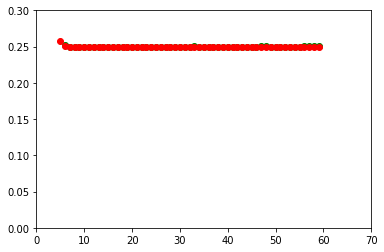

Minimum Testing Loss: 0.250047


In [19]:
print(global_train_loss)
print(global_test_loss)
import matplotlib.pyplot as plt
%matplotlib inline 
plt.ion()
x = range(60) 
plt.axis([0,70,0,0.3])
plt.plot(x,global_train_loss,'go',x,global_test_loss,'ro')
plt.show()

print('Minimum Testing Loss: '+str(np.min(global_test_loss)) )

In [ ]:
print(reviews[92])